In [101]:
import os
import re
import sklearn
import numpy as np
import pandas as pd
from wombat.engine import ml_model
from wombat.engine import parse_input_description as parse_title
from wombat.engine.parse_input_description import create_one_hot_row_brand_keyword
from wombat.models import Item, Brand
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from wombat.models import dbsession, engine, ItemType, ItemAdjective
from sklearn.metrics import mean_absolute_error
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,12)

# suppress pandas warning about operations on copies of dfs
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 1000)

In [73]:
df = ml_model.canonical_df

# split data into train and test group
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# copy of train before we delete the 'rent_per_week' and 'title' field. We want title 
# we will need these things before we make dummy variables
df_full_training = df[df['is_train']==True]
df_full_test = df[df['is_train']==False]

# get one-hot columns for item_types
dummified_items = pd.get_dummies(df['item_type'])
df = pd.concat([df, dummified_items], axis = 1)

df = df.drop(['item_type'], axis = 1)
print(len(dummified_items.columns))
print(len(df.columns))

11
17


## Dummify brands

In [74]:
df_brands = pd.read_sql_query('SELECT * FROM "brands"', con=engine)

brands = df_brands['name'].values
keywords = df_brands['keywords'].values

# unknown brands are brands we pull from the large df. 
# They may be mislabeled so we need to sort them and one-hot them to a known list of brands
unknown_brands = df['brand'].values

one_hotted_brands = []

for unknown_brand in unknown_brands:
    one_hotted_brands.append(create_one_hot_row_brand_keyword(unknown_brand, keywords))
    
df_brands = pd.DataFrame(one_hotted_brands, columns = brands, index = df.index.values)
df = pd.concat([df, df_brands], axis = 1)

df = df.drop(['brand'], axis = 1)
df

,title,cost,rent_per_week,description,is_train,accessories,bags,bottoms,dresses,outerwear,pants,rompers,shirts,shoes,skirts,tops,Tadashi Shoji,other brand,Alice + Olivia,For Love & Lemons,Adrianna Papell,Parker,Nicole Miller,Dress the Population,Lovers + Friends,Halston Heritage,Chanel,Elizabeth and James,Herve Leger,Calvin Klein,Trina Turk,Mara Hoffman,Self-Portrait,Milly,Suno,DVF,Ted Baker,Tibi,Badgley Mischka,Black Halo,Aidan Mattox,Helmut Lang,Haute Hippie,French Connection,Rebecca Taylor,Rachel Zoe,Yves Saint Laurent,Laundry by Shelli Segal,Christian Louboutin,Shoshanna,Kate Spade,The Jetset Diaries,Clover Canyon,Free People,Theory,Kristi Vosbeck,Keepsake the Label,Gucci,Nanette Lepore,Donna Morgan,Three Floor,Zimmermann,Jay Godfrey,Bebe,Eliza J,Topshop,Vera Wang,Alexander Wang,ABS,Rag & Bone,A.L.C.,Reformation,Missoni,Robert Rodriguez,Needle & Thread,Xscape,Tracy Reese,Sue Wong,Vince Camuto,Vince,Valentino,Burberry,Jonathan Simkhai,Elie Tahari,Cynthia Steffe,Karen Millen,Jimmy Choo,Alexander McQueen,Fendi,Betsey Johnson,JS Collections,Zac Posen,Betsey Johnson,Diane von Furstenberg,3.1 Phillip Lim,J.Crew,Torn by Ronny Kobo,DKNY,Rachel Pally,All Saints,Guess,Jill Jill Stuart,Michael Kors,Joie,Faviana,Mac Duggal,Alfred Sung,Ralph Lauren,Solace London,Tory Burch,Louis Vuitton,Lilly Pulitzer,Balenciaga,Untamed,Cushnie Et Ochs,M Missoni,Opening Ceremony,Milly,Wes Gordon,Cynthia Rowley,Alexis,Marc Jacobs,Just Cavalli,Prada,Stella & Dot,Ella Moss,Catherine Malandrino,Betsy & Adam,Reiss,Blondie Nites,Rebecca Minkoff,Parker,Zara,The Kooples,Mimilore,Sachin + Babi,Sherri Hill,RVN,Schutz,Chloé,Versace,Calvin Klein,Sean Collection,Marciano,Foley & Corina,Equipment,MSGM,Cache,Sandro,Halston Heritage,Joseph,Lela Rose,Monique Lhuillier,Isabel Marant,StyleStalker,Rachel Roy,Erin Fetherston,Juicy Couture,Lipsy,Givenchy,Stella McCartney,Issa,Club Monaco,Emilio Pucci,Everly,L'Agence,Glamour by Terani Couture,White House|Black Market,Oscar de la Renta,Camilla,DearMissJ,Armani Exchange,Kenzo,ASOS,AQ/AQ,Carven,Loeffler Randall,Intermix,Theia,Miu Miu,Alice McCall,Hale Bob,Roberto Cavalli,Max and Cleo,Anthropologie,FAVIANA,Karen Walker,Banana Republic,Gryphon,Hayley Paige Occasions,Nicole Bakti,Narciso Rodriguez,Lanvin,Yoana Baraschi,Badgley Mischka,Alaia,Kay Unger,Style Lend,Missoni,Mynt,cooper & ella,Philip Lim,Coach,Balmain,"Young, Fabulous & Broke",Giuseppe Zanotti,Reformation,Carmella,Via Spiga,Escada,Hugo Boss,Thakoon,Maison Scotch,Prabal Gurung,Ceremony by Joanna August,Frame Denim,Jonathan Saunders,Iro,Giorgio Armani,Marni,Amanda Uprichard,Dolce & Gabbana,Maje,Jenny Yoo,Jason Wu,Stone Cold Fox,French Connection,La Femme,Rory Beca,Max Mara,Yumi Kim,IGIGI,Terani Couture,Salvatore Ferragamo,Maggy London,Katya Lee Designs,BCBG
0,Ava guipure lace mini dress,520.0,99.0,Self-Portrait's 'Ava' mini dress is perfect fo...,False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Lurex Dress,695.0,69.0,"Tibi Detailed with metallic gold fil coupe, th...",True,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Sexy Strass 100 Swarovski crystal peep-toe pumps,1977.0,125.0,"A stunning bridal option, Christian Louboutin'...",True,0,0,0,0,0,

In [75]:
print(len(df.columns))

237


In [76]:
# get list of adjective features form database
features_adj = [f.name for f in dbsession.query(ItemAdjective).all()]

#tokenized_titles = []
#for title in df['title']:
#    parse_title.create_one_hot_row_adj(title, features_adj)
#    tokenized_titles.append(parse_title.create_one_hot_row_adj(title, features_adj))
#df_adj = pd.DataFrame(tokenized_titles, columns = features_adj, index = df.index.values)

tokenized_titles = []
for text_array in df[['title', 'description']].values:
    try:
        text = ' '.join(text_array)
    except TypeError:
        text = text_array[0]
    tokenized_titles.append(parse_title.create_one_hot_row_adj(text, features_adj))
df_adj = pd.DataFrame(tokenized_titles, columns = features_adj, index = df.index.values)
df_w_adj = pd.concat([df, df_adj], axis = 1)

In [87]:
final_df = df_w_adj
features = final_df.columns.drop(['rent_per_week', 'title', 'is_train', 'description']) # just column names
train, test = final_df[final_df['is_train']==True], final_df[final_df['is_train']==False]

In [89]:
reg = RandomForestRegressor(n_jobs=2, n_estimators=10)

reg.fit(train[features], train['rent_per_week'].apply(np.log))
predicted = np.exp(reg.predict(test[features]))

X_sample = pd.Series(0, index = train[features].columns)
model_dir = '/home/patrick/Dropbox/insight/wombat/wombat/engine/stat_model_pickles'
model_path = os.path.join(model_dir, 'rfr_v0.3_w_adj_prices_better_brands.pkl')
joblib.dump([X_sample, reg], model_path)
#call this with: clf = joblib.load('huber_v0.1.pkl')
#rfr_predicted
#stopping_value = np.minimum(np.maximum(test['rent_per_week'].values), np.maximum(rfr_predicted))

['/home/patrick/Dropbox/insight/wombat/wombat/engine/stat_model_pickles/rfr_v0.3_w_adj_prices_better_brands.pkl']

Slope of regression line for obs v pred:  [ 0.53742484]
mean_absolute_error: 10.37425959783926
R^2:  0.57202049242495
Length of df_full_test: 1443
530


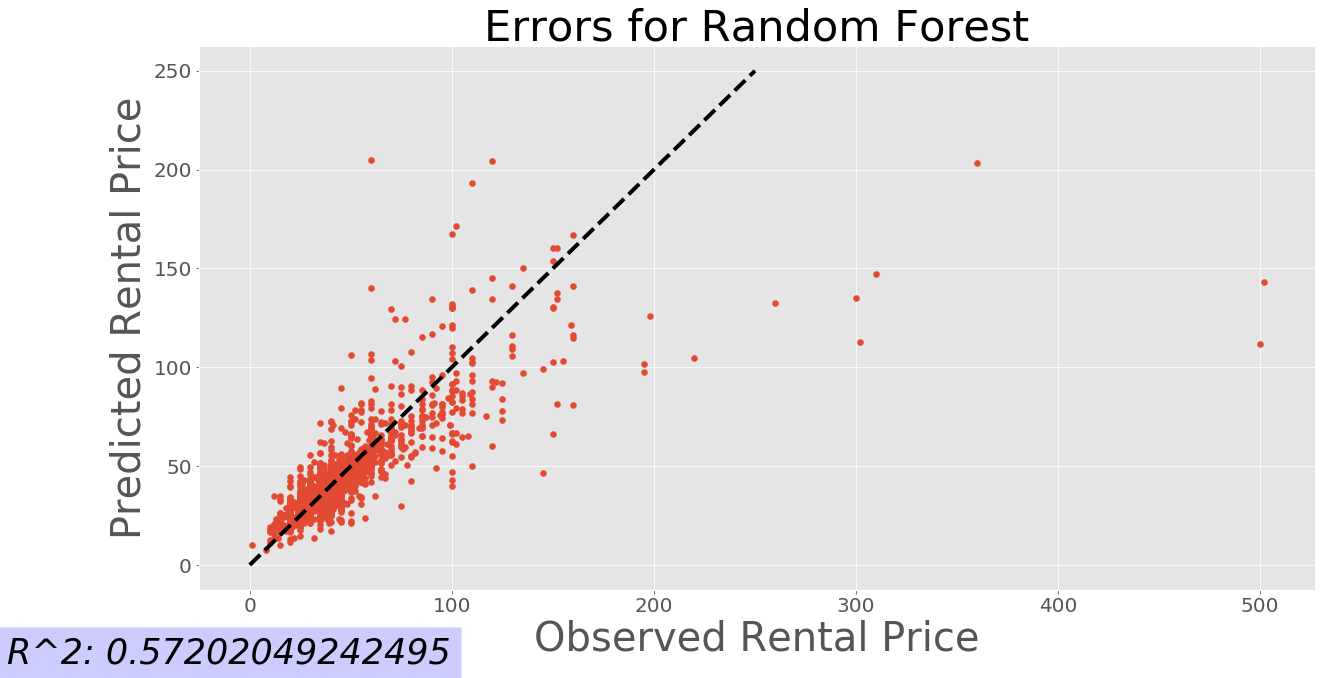

In [90]:
import matplotlib
from sklearn.metrics import r2_score

matplotlib.rcParams.update({'font.size': 30})
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# Create linear regression object for predicted vs measured
error_reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(predicted)

# Train the model using the training sets
error_reg.fit(x, y)

r2 = r2_score(test['rent_per_week'], predicted)

# The coefficients
print('Slope of regression line for obs v pred: ', error_reg.coef_)
print("mean_absolute_error: {}".format(mean_absolute_error(test['rent_per_week'], predicted)))
print("R^2:  {}".format(r2))
      
# Plot outputs
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x = test['rent_per_week'], y = predicted)
stopping_value = 250
ax.plot([0, stopping_value], [0, stopping_value], 'k--', lw=4, color="black")
ax.set_title('Errors for Random Forest')
ax.set_xlabel('Observed Rental Price', fontsize=40)
ax.set_ylabel('Predicted Rental Price', fontsize=40)
#ax.plot(x, error_reg.predict(x), 'k--', color='black', linewidth=3)

ax.text(-120, -50, 'R^2: {}'.format(r2), style='italic', fontsize=35,
bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})

x = test['rent_per_week']
df_full_test['predicted_rent'] = predicted
#df_full_test['error'] = df_full_test[['rent_per_week', 'predicted_rent']].subtract(axis=1)
df_full_test['error'] = df_full_test['rent_per_week'] - df_full_test['predicted_rent']
df_full_test['abs_error'] = np.abs(df_full_test['rent_per_week'] - df_full_test['predicted_rent'])
print("Length of df_full_test: {}".format(len(df_full_test)))
#df_full_test['error'] = df_full_test['error'].abs()

# calculate number of items within a certain range
d_errors = df_full_test
num_low_errors = d_errors[(d_errors['error'] > 0) & (d_errors['error'] < 10)]
print(len(num_low_errors))

In [85]:
brands_query = "SELECT * FROM brands;"
brands = [b[1] for b in engine.execute(brands_query).fetchall()]
keywords = [b[2] for b in engine.execute(brands_query).fetchall()]
keywords
create_one_hot_row_brand_keyword(unknown_brand, keywords)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [113]:
model_dir = '/home/patrick/Dropbox/insight/wombat/wombat/engine/stat_model_pickles'
model_path = os.path.join(model_dir, 'rfr_v0.3_w_adj_prices_better_brands.pkl')
X_sample, reg = joblib.load(model_path)

In [114]:
brand = 'Tibi'
item_type = "dresses"
title = 'Lurex Dress'
est_price = 10

X_sample['cost'] = 10
X_sample[brand] = 1
X_sample[item_type] = 1
#X_sample.loc[X_sample['']]
adjectives_query = "SELECT * FROM item_adjectives;"
adjectives = [a[1] for a in engine.execute(adjectives_query).fetchall()]
for adj in adjectives:
    match = re.search('{}'.format(adj), title, re.IGNORECASE)
    if match:
        #l.append(1)
        try:
            X_sample[adj] = 1
        except TypeError:
            pass
X_sample

cost                         10
accessories                   0
bags                          0
bottoms                       0
dresses                       1
outerwear                     0
pants                         0
rompers                       0
shirts                        0
shoes                         0
skirts                        0
tops                          0
Tadashi Shoji                 0
other brand                   0
Alice + Olivia                0
For Love & Lemons             0
Adrianna Papell               0
Parker                        0
Nicole Miller                 0
Dress the Population          0
Lovers + Friends              0
Halston Heritage              0
Chanel                        0
Elizabeth and James           0
Herve Leger                   0
Calvin Klein                  0
Trina Turk                    0
Mara Hoffman                  0
Self-Portrait                 0
Milly                         0
Suno                          0
DVF     